In [1]:
from __future__ import print_function
from pathlib import Path
from torchvision.utils import make_grid, save_image
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from os import listdir
from os.path import join
from torchvision import datasets, transforms
import copy
import enum
import warnings
import tempfile
import subprocess
import multiprocessing
import random
import torch
import torch.nn.functional as F
import openslide
import torchvision
import gc
import PIL
import numpy as np
import ipyplot

#https://colab.research.google.com/github/fepegar/torchio-notebooks/blob/main/notebooks/TorchIO_tutorial.ipynb#scrollTo=Wi4v_xRe_0kG
#https://discuss.pytorch.org/t/dataloader-with-mini-batch-sampling/21873

In [2]:
#old, first convert to png, process patches, then load dir with patches in loader
transform = transforms.Compose([
    transforms.ToTensor(),
])
input_data = torchvision.datasets.ImageFolder(root="/data/luberjm/data/training_set",transform=transform)
ilength = len(input_data)
print(ilength)
loader1 = torch.utils.data.DataLoader(input_data,batch_size=10, shuffle=True)
it1 = iter(loader1)
first1 = next(it1)

36884


<class 'list'>
<class 'torch.Tensor'>
torch.Size([10, 3, 512, 512])



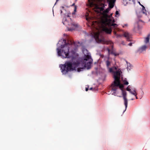
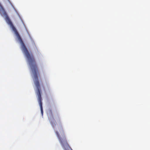
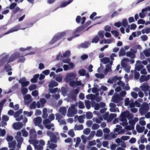
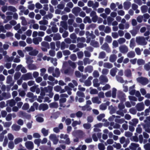
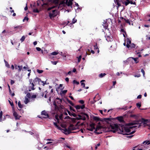
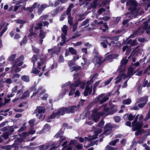
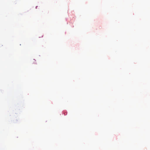
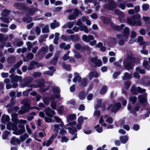
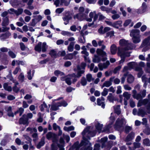
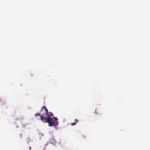


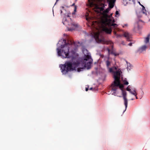
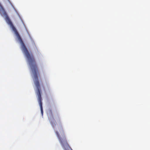
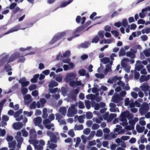
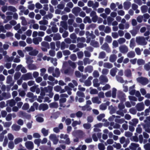
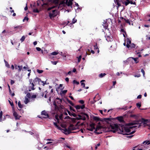
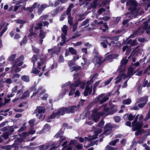
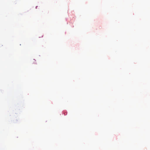
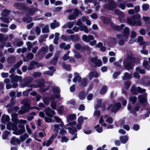
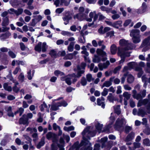
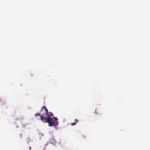

In [3]:
print(type(first1))
print(type(first1[0]))
print(first1[0].shape)
trans = transforms.ToPILImage()
ipyplot.plot_images(list(map(lambda x: trans(x),first1[0])))


In [2]:
class SvsDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, patch_size, num_patches,overlap_frac):
        print("init")
        super(SvsDatasetFromFolder, self).__init__()
        self.imageFilenames = []
        self.imageFilenames.extend(join(dataset_dir, x) for x in sorted(listdir(dataset_dir)))
        self.patchSize = patch_size
        self.numPatches = num_patches
        self.sampled_coords = []
        self.allowedOverlap = overlap_frac
    def _load_file(self, index):
        print("loading")
        filename = self.imageFilenames[index]
        wsi_obj = openslide.open_slide(str(self.imageFilenames[index]))
        svs_i = wsi_obj.read_region(location=(0, 0), level=0, size=wsi_obj.level_dimensions[0])
        w_ = int(svs_i.width)
        h_ = int(svs_i.height) 
        return svs_i
    def _get_intersection(self,a_x,a_y,b_x,b_y): #tensors are row major
        if abs(a_x - b_x) < self.patchSize and abs(a_y - b_y) < self.patchSize:
            return True
        else:
            return False
    def _get_intersections(self,x,y):
        if len(self.sampled_coords) == 0:
            return True
        else:
            ml = set(map(lambda b: self._get_intersection(b[0],b[1],x,y), self.sampled_coords))
            if True in ml:
                return False
            else: 
                return True
    def _filter_whitespace(self,tensor_3d):
        r = np.mean(np.array(tensor_3d[0]))
        g = np.mean(np.array(tensor_3d[1]))
        b = np.mean(np.array(tensor_3d[2]))
        channel_avg = np.mean(np.array([r,g,b]))
        if channel_avg < .82:
            return True
        else:
            return False
    def _patching(self, img):
        print("patching")
        imgt = transforms.ToTensor()(img)
        #del img
        #gc.collect() #avoid doing this as much as possible
        print("transformed")
        img_tensor_stack = []
        count = 0
        while count < self.numPatches: #[4, x , y] -> many [4, 512, 512]
                rand_i = random.randint(0,imgt.shape[1]-self.patchSize)
                rand_j = random.randint(0,imgt.shape[2]-self.patchSize)
                temp = imgt[:3, rand_i:rand_i + self.patchSize, rand_j:rand_j + self.patchSize] #take the patch and remove alpha channel
                if self._filter_whitespace(temp):
                    if self._get_intersections(rand_j,rand_i):
                        self.sampled_coords.append((rand_j,rand_i))
                        img_tensor_stack += [temp]
                        count += 1
        return img_tensor_stack
    def __getitem__(self, index):
        img = self._load_file(index)
        img_p = self._patching(img)
        return img_p 
    def __len__(self):
        return len(self.imageFilenames)

In [7]:
#new
input_data = SvsDatasetFromFolder("/data/luberjm/data/lungadeno/svs",512,20,0.5)
train_loader = torch.utils.data.DataLoader(input_data,batch_size=1, shuffle=True)
data_iter = iter(train_loader)
batch = next(data_iter)

init
loading
patching
transformed
true


<class 'list'>
<class 'torch.Tensor'>
torch.Size([1, 3, 512, 512])
torch.Size([3, 512, 512])



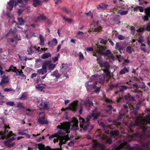
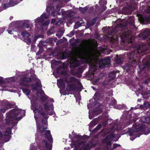
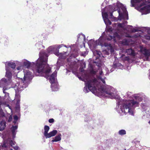
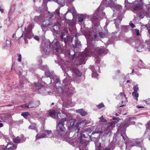
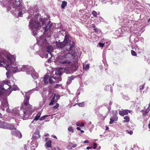
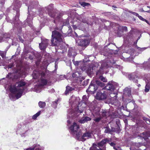
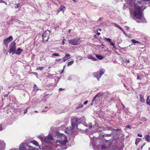
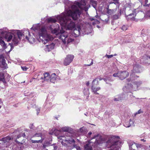
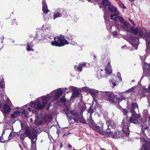
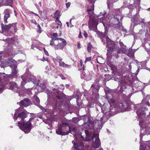
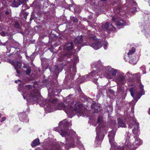
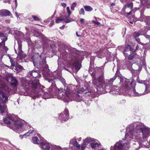
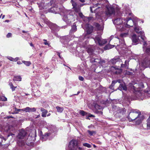
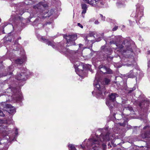
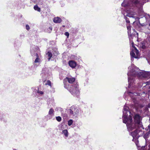
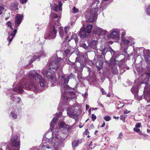
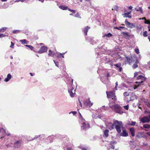
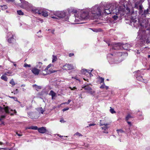
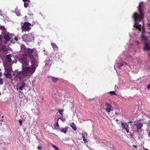
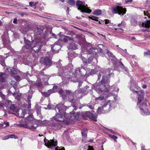


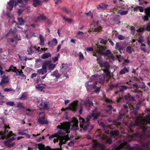
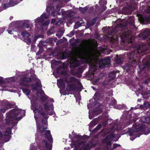
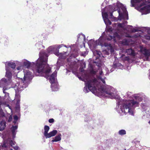
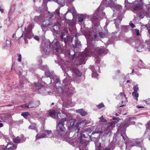
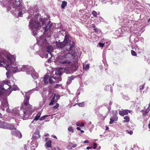
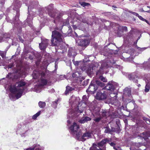
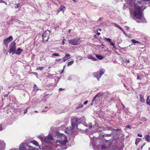
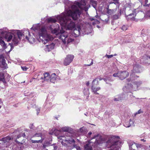
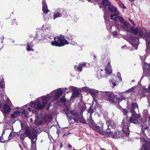
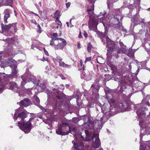
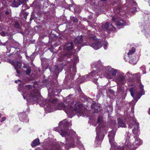
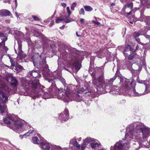
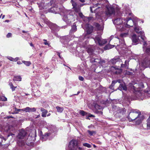
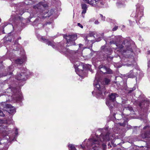
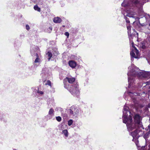
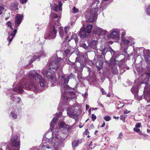
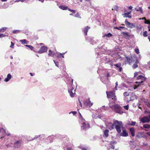
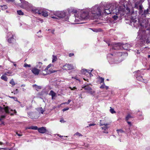
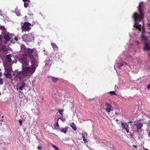
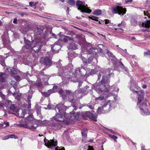

In [8]:
print(type(batch))
print(type(batch[0]))
print(batch[0].shape)
print(batch[0][0].shape)
trans = transforms.ToPILImage()
ipyplot.plot_images(list(map(lambda x: trans(x[0]),batch)))
#im2 = trans(batch[0][0])
#im2.show()


In [34]:
#to do's: whitespace filtering, minibatching

#depth wise seperatable convolution, if codex has 19 channels use same filter to have exactly the same structure regardless of input

In [18]:
np.mean(np.array(batch[0][0][2]))


0.6753029

In [6]:
a = [1,2,3]
b = [(1,2),(3,4),(5,6)]
c = zip(a,b)
max(c)

(3, (5, 6))

In [3]:
input_data = SvsDatasetFromFolder("/data/luberjm/data/lungadeno/svs",512,20,0.5)
train_loader = torch.utils.data.DataLoader(input_data,batch_size=1, shuffle=True)
for epoch in range(0, 2):
    count = 0
    for _,train_data in enumerate(train_loader):
        count+=1
        print(count)
        trans = transforms.ToPILImage()
        ipyplot.plot_images(list(map(lambda x: trans(x[0]),batch)))

init
loading
patching
transformed
1


NameError: name 'batch' is not defined